# Training


This notebook shows the overall training process of the 3 approaches mentioned in the paper:

- Disease detection
- Symptom identification
- Combined task

We describe the key library imports, outline the modeling process as defined in the paper, and discuss the training loop implemented for each task.

In [ ]:
#  Hiding some imports for brevity
import json
import seaborn as sns
import matplotlib.pyplot as plt
from iragca.matplotlib import Styles
from tqdm import tqdm


plt.style.use(Styles.ML.value)

# Introduction

To train the models, we will be using the [PyTorch](10.48550/arXiv.1912.01703) framework and its broader ecosystem. PyTorch provides a flexible and modular API for defining neural network architectures, enabling us to construct custom convolutional networks, configure pretrained backbones, and experiment with alternative model designs as needed.

In [ ]:
import torch

## Building SimpleCNN

![simplecnn](/docs/images/figure6/simplecnn.png)



| Layer | Type      | Kernel | Padding | Stride | Input Shape          | Output Shape   | 
| ----- | --------- | ------ | ------- | ------ | -------------------- | -------------- | 
| 1     | Conv2d    | 3×3    | 1       | 1      | ` 3 × 32 × 32`       | `16 × 33 × 33` |
| 2     | MaxPool2d | 2×2    | 0       | 2      | `16 × 33 × 33`       | `16 × 16 × 16` |
| 3     | Conv2d    | 3×3    | 1       | 1      | `16 × 16 × 16`       | `32 × 17 × 17` |
| 4     | MaxPool2d | 2×2    | 0       | 2      | `32 × 17 × 17`       | `32 ×  8 ×  8` |
| 5     | Flatten   | —      | —       | —      | `32 ×  8 ×  8`       | `2048`         |
| 6     | Linear    | —      | —       | —      | `2048`               | `128`          | 
| 7     | Linear    | —      | —       | —      | `128`                | `output_dim`   | 


In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, channels: int, output_dim: int = 1):
        super(SimpleCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, x):
        return self.network(x)

### Image sizes

We verify the image sizes after each convolution and pooling layer. For an input image of size $ W \times W $, the output spatial dimension after a convolution is:
$$
W_{\text{out}} = \left\lfloor\frac{W_{\text{in}} + 2P - K}{S}\right\rfloor + 1
$$
Where:

| Symbol             | Meaning                           |
| ------------------ | --------------------------------- |
| $W_{\text{in}}$  | Input width/height (square image) |
| $W_{\text{out}}$ | Output width/height               |
| $K$              | Kernel size                       |
| $P$              | Padding                           |
| $S$              | Stride                            |




In [63]:
def calc_out(image_width, filter_size, stride: int = 1, padding: int = 0):
    """
    Calculate output shape of a matrix after a convolution.
    The results are only applicable for square matrix kernels and images only.
    """
    image_size = ((image_width - filter_size + 2 * padding) // stride) + 1
    return image_size

conv1 = calc_out(32, 2, 1, 1)
print("Conv2d:", conv1)
conv2 = calc_out(conv1, 2, 2, 0)
print("MaxPool2Dconv2:", conv2)
conv3 = calc_out(conv2, 2, 1, 1)
print("Conv2d:", conv3)
conv4 = calc_out(conv3, 2, 2, 0)
print("MaxPool2Dconv4:", conv4)

Conv2d: 33
MaxPool2Dconv2: 16
Conv2d: 17
MaxPool2Dconv4: 8


At the final pooling layer we get an image size of 8x8 pixels.

## Training imports

In [ ]:
from iragca.ml import RunLogger
from torch.nn import CrossEntropyLoss, MSELoss
from torch.optim import SGD

## Evaluation metrics

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

## Load and Preprocess

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from lib.config import Directories
from lib.data import ( 
    MegaPlantDataset, 
    UnhealthyMegaPlantDataset, 
    CombinedMegaPlantDataset 
)

In [ ]:
IMAGE_SIZE = (32, 32)

In [ ]:
transform_pipeline = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

megaplant = MegaPlantDataset(
    data_path=Directories.INTERIM_DATA_DIR.value / "leaves", transforms=transform_pipeline
    )

unhealthy_megaplant = UnhealthyMegaPlantDataset(
    data_path=Directories.INTERIM_DATA_DIR.value / "leaves", transforms=transform_pipeline
    )

combined_megaplant = CombinedMegaPlantDataset(
    data_path=Directories.INTERIM_DATA_DIR.value / "leaves", transforms=transform_pipeline
    )

# Training

In [41]:
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.01
OPTIMIZER = SGD
SPLIT_RATIO = [0.7, 0.2, 0.1]
THRESHOLD = 0.5

In [38]:
def plot_results(logger: RunLogger) -> None:
    fig, ax = plt.subplots(1, 3, figsize=(12, 2.5))

    sns.lineplot(x=logger.steps, y=logger.train_loss, label='Train Loss', ax=ax[0])
    sns.lineplot(x=logger.steps, y=logger.val_loss, label='Validation Loss', ax=ax[0])
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss over Epochs')

    sns.lineplot(x=logger.steps, y=logger.train_acc, label='Train Accuracy', ax=ax[1])
    sns.lineplot(x=logger.steps, y=logger.val_acc, label='Validation Accuracy', ax=ax[1])
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy over Epochs')

    sns.lineplot(x=logger.steps, y=logger.train_f1, label='Train F1 Score', ax=ax[2])
    sns.lineplot(x=logger.steps, y=logger.val_f1, label='Validation F1 Score', ax=ax[2])
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('F1 Score')
    ax[2].set_title('F1 Score over Epochs')

In [5]:
def save_trained_model(model: torch.nn.Module, model_name: str) -> None:
    torch.save(model.state_dict(), Directories.MODELS_DIR.value / f"{model_name}.pth")

def save_training_results(logger: RunLogger, model_name: str) -> None:
    with open(Directories.MODELS_DIR.value / f"{model_name}_train_results.json", "w") as f:
        json.dump(logger.get_logs(), f)

def load_training_results(model_name: str) -> dict:
    with open(Directories.MODELS_DIR.value / f"{model_name}_train_results.json", "r") as f:
        return json.load(f)

## Disease Detection

In [48]:
train_data, val_data, test_data = random_split(megaplant, SPLIT_RATIO)

train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=True)

In [ ]:
disease_detection_model = SimpleCNN(channels=3, output_dim=1)
optimizer = OPTIMIZER(disease_detection_model.parameters(), lr=LEARNING_RATE)
criterion = MSELoss()

def train(model, optimizer, criterion, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    logger = RunLogger(
        epochs, 
        display_progress=True, 
        update_interval=1, 
        notebook=False, 
        unit="epoch", 
        desc="Epochs",
        position=0
    )

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        y_trues, y_preds = [], []

        for inputs, targets in tqdm(train_loader, total=len(train_loader), position=1, leave=False, desc="Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), targets.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            y_pred = (outputs >= THRESHOLD).long().view(-1)
            y_trues.extend(targets.cpu().numpy())
            y_preds.extend(y_pred.cpu().tolist())

        train_loss = total_loss / len(train_loader)
        train_accuracy = accuracy_score(y_trues, y_preds)
        train_f1_score = f1_score(y_trues, y_preds)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_y_trues, val_y_preds = [], []
            for inputs, targets in tqdm(val_loader, total=len(val_loader), position=1, leave=False, desc="Validating"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1), targets.float())
                val_loss += loss.item()
                val_y_trues.extend(targets.cpu().numpy())
                val_y_preds.extend((outputs >= THRESHOLD).long().cpu().numpy())
            val_loss = val_loss / len(val_loader)
            val_accuracy = accuracy_score(val_y_trues, val_y_preds)
            val_f1_score = f1_score(val_y_trues, val_y_preds)

        logger.log_metrics({
            'train_loss': train_loss,
            'train_acc': train_accuracy,
            'train_f1': train_f1_score,
            'val_loss': val_loss,
            'val_acc': val_accuracy,
            'val_f1': val_f1_score
            }, epoch)

    return logger

disease_detection_logger = train(disease_detection_model, optimizer, criterion, epochs=EPOCHS)

In [ ]:
# # ============
# # Uncomment this cell to save
# # this model and training results
# # to the disk
# # ============

# model_name = "disease_detection_model"
# save_trained_model(disease_detection_model, model_name)
# save_training_results(disease_detection_logger, model_name)

In [ ]:
# # ============
# # Uncomment this cell to load
# # the model and training results
# # from the disk
# # ============

# model_name = "disease_detection_model"
# disease_detection_model = SimpleCNN(channels=3, output_dim=1)
# disease_detection_model.load_state_dict(torch.load(Directories.MODELS_DIR.value / f"{model_name}.pth"))
# disease_detection_logger = RunLogger.from_logs(load_training_results(model_name))

/tmp/ipykernel_227840/2689614935.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


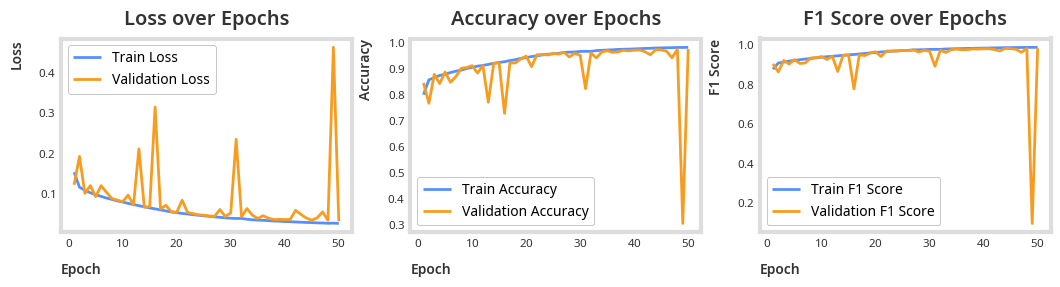

In [20]:
plot_results(disease_detection_logger)

In [7]:
total_params = sum(p.numel() for p in disease_detection_model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 267489


### Testing

In [49]:
disease_detection_model.eval()

all_preds, all_targets = [], []

with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    disease_detection_model.to(device)
    for inputs, targets in tqdm(test_loader, total=len(test_loader), desc="Testing", unit="batch"):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = disease_detection_model(inputs)
        preds = (outputs >= THRESHOLD).long().view(-1)
        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

Testing: 100%|██████████| 189/189 [01:09<00:00,  2.70batch/s]


In [50]:
f1 = f1_score(all_targets, all_preds, average='weighted')
accuracy = accuracy_score(all_targets, all_preds)
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

F1 Score: 0.5457
Accuracy: 0.5188


## Symptom Identification

In [ ]:
train_data, val_data, test_data = random_split(unhealthy_megaplant, SPLIT_RATIO)

train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

In [ ]:
symptom_identification_model = SimpleCNN(channels=3, output_dim=len(unhealthy_megaplant.SYMPTOM_MAP))
optimizer = OPTIMIZER(symptom_identification_model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

def train(model, optimizer, criterion, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    logger = RunLogger(
        epochs, 
        display_progress=True, 
        update_interval=1, 
        notebook=False, 
        unit="epoch", 
        desc="Epochs",
        position=0
    )

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        train_preds, train_targets = [], []

        for inputs, targets in tqdm(train_loader, total=len(train_loader), position=1, leave=False, desc="Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_pred = outputs.argmax(dim=1).cpu().numpy()
            train_target = targets.cpu().numpy()
            train_preds.extend(train_pred)
            train_targets.extend(train_target)

        train_loss = total_loss / len(train_loader)
        train_f1 = f1_score(train_targets, train_preds, average='weighted')
        train_acc = accuracy_score(train_targets, train_preds)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_preds, val_targets = [], []
            for inputs, targets in tqdm(val_loader, total=len(val_loader), position=1, leave=False, desc="Validating"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_pred = outputs.argmax(dim=1).cpu().numpy()
                val_target = targets.cpu().numpy()
                val_preds.extend(val_pred)
                val_targets.extend(val_target)

            val_loss = val_loss / len(val_loader)
            val_f1 = f1_score(val_targets, val_preds, average='weighted')
            val_acc = accuracy_score(val_targets, val_preds)

        logger.log_metrics({
            'train_loss': train_loss,
            'train_f1': train_f1,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_f1': val_f1,
            'val_acc': val_acc,
            }, epoch)

    return logger

symptom_identification_logger = train(symptom_identification_model, optimizer, criterion, epochs=EPOCHS)

In [ ]:
# # ============
# # Uncomment this cell to save
# # this model and training results
# # to the disk
# # ============

# model_name = "symptom_identification_model"
# save_trained_model(symptom_identification_model, model_name)
# save_training_results(symptom_identification_logger, model_name)

In [ ]:
# # ============
# # Uncomment this cell to load
# # the model and training results
# # from the disk
# # ============

# model_name = "symptom_identification_model"
# symptom_identification_model = SimpleCNN(channels=3, output_dim=len(unhealthy_megaplant.SYMPTOM_MAP))
# symptom_identification_model.load_state_dict(torch.load(Directories.MODELS_DIR.value / f"{model_name}.pth"))
# symptom_identification_logger = RunLogger.from_logs(load_training_results(model_name))

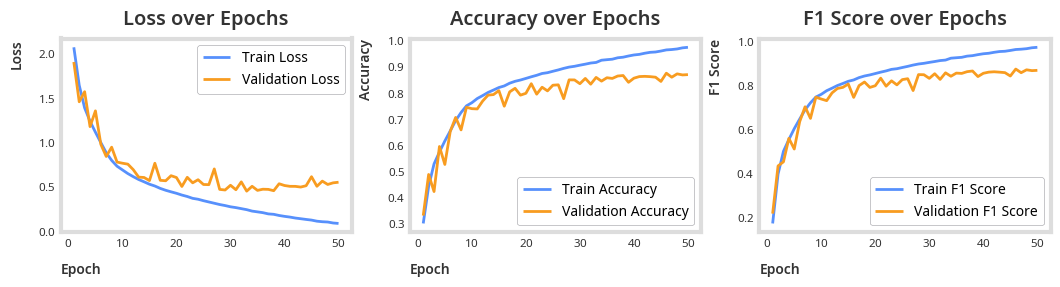

In [39]:
plot_results(symptom_identification_logger)

In [ ]:
total_params = sum(p.numel() for p in symptom_identification_model.parameters())
print(f"Total parameters: {total_params}")

### Testing

In [32]:
symptom_identification_model.eval()

all_preds, all_targets = [], []

with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    symptom_identification_model.to(device)
    for inputs, targets in tqdm(test_loader, total=len(test_loader), desc="Testing", unit="batch"):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = symptom_identification_model(inputs)
        test_pred = outputs.argmax(dim=1)
        all_preds.extend(test_pred.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

Testing: 100%|██████████| 139/139 [00:59<00:00,  2.33batch/s]


In [33]:
print(classification_report(all_targets, all_preds))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       646
           1       0.98      0.99      0.99       568
           2       0.99      0.98      0.98       550
           3       0.96      0.94      0.95       282
           4       0.91      0.91      0.91       383
           5       0.94      0.84      0.89       109
           6       0.98      0.76      0.86        55
           7       0.98      0.94      0.96       175
           8       0.95      0.93      0.94       165
           9       0.89      0.93      0.91        69
          10       0.91      0.95      0.93      1309
          11       0.99      0.96      0.97       116

    accuracy                           0.94      4427
   macro avg       0.95      0.92      0.93      4427
weighted avg       0.94      0.94      0.94      4427



## Combined task

In [ ]:
train_data, val_data, test_data = random_split(combined_megaplant, SPLIT_RATIO)

train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

In [ ]:
combined_identification_model = SimpleCNN(channels=3, output_dim=len(combined_megaplant.CLASS_MAP))
optimizer = OPTIMIZER(combined_identification_model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

def train(model, optimizer, criterion, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    logger = RunLogger(
        epochs, 
        display_progress=True, 
        update_interval=1, 
        notebook=True, 
        unit="epoch", 
        desc="Epochs",
        position=0
    )

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        train_preds, train_targets = [], []

        for inputs, targets in tqdm(train_loader, total=len(train_loader), position=1, leave=False, desc="Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_pred = outputs.argmax(dim=1).cpu().numpy()
            train_target = targets.cpu().numpy()
            train_preds.extend(train_pred)
            train_targets.extend(train_target)

        train_loss = total_loss / len(train_loader)
        train_f1 = f1_score(train_targets, train_preds, average='weighted')
        train_acc = accuracy_score(train_targets, train_preds)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_preds, val_targets = [], []
            for inputs, targets in tqdm(val_loader, total=len(val_loader), position=1, leave=False, desc="Validating"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_pred = outputs.argmax(dim=1).cpu().numpy()
                val_target = targets.cpu().numpy()
                val_preds.extend(val_pred)
                val_targets.extend(val_target)

            val_loss = val_loss / len(val_loader)
            val_f1 = f1_score(val_targets, val_preds, average='weighted')
            val_acc = accuracy_score(val_targets, val_preds)

        logger.log_metrics({
            'train_loss': train_loss,
            'train_f1': train_f1,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_f1': val_f1,
            'val_acc': val_acc,
            }, epoch)

    return logger

combined_identification_logger = train(combined_identification_model, optimizer, criterion, epochs=EPOCHS)

In [ ]:
# # ============
# # Uncomment this cell to save
# # this model and training results
# # to the disk
# # ============

# model_name = "combined_identification_model"
# save_trained_model(combined_identification_model, model_name)
# save_training_results(combined_identification_logger, model_name)

In [ ]:
# # ============
# # Uncomment this cell to load
# # the model and training results
# # from the disk
# # ============

# model_name = "combined_identification_model"
# combined_identification_model = SimpleCNN(channels=3, output_dim=len(combined_megaplant.CLASS_MAP))
# combined_identification_model.load_state_dict(torch.load(Directories.MODELS_DIR.value / f"{model_name}.pth"))
# combined_identification_logger = RunLogger.from_logs(load_training_results(model_name))

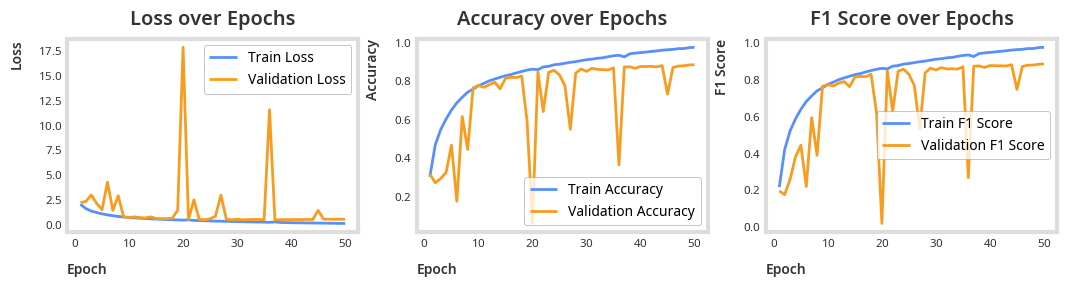

In [40]:
plot_results(combined_identification_logger)

### Testing

In [42]:
all_preds, all_targets = [], []

combined_identification_model.eval()
combined_identification_model.to("cuda")
for inputs, targets in tqdm(test_loader, desc="Testing", unit="batch"):
    inputs, targets = inputs.to("cuda"), targets.to("cuda")
    with torch.no_grad():
        outputs = combined_identification_model(inputs)
        test_pred = outputs.argmax(dim=1)
        all_preds.extend(test_pred.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

Testing: 100%|██████████| 189/189 [01:04<00:00,  2.94batch/s]


In [43]:
print(classification_report(all_targets, all_preds))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       663
           1       0.99      0.97      0.98       553
           2       0.98      0.98      0.98       546
           3       0.98      0.96      0.97       262
           4       0.89      0.92      0.90       369
           5       0.94      0.89      0.92        95
           6       0.89      0.83      0.86        47
           7       0.92      0.97      0.95       184
           8       0.95      0.94      0.95       165
           9       0.91      0.85      0.88        93
          10       0.93      0.94      0.94      1333
          11       0.99      0.96      0.98       114
          12       0.98      0.98      0.98      1596

    accuracy                           0.95      6020
   macro avg       0.94      0.93      0.94      6020
weighted avg       0.95      0.95      0.95      6020



# Summary